In [1]:
import torch
import torch.nn as nn
import re
import pdfplumber
import unicodedata
from typing import List
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from IPython.display import Markdown, display, Video
%load_ext jupyter_tikz

assesment_draw_and_fill = True

**Disclaimer:** This notebook pretends to be didactic, introducing the ideas behind the concepts used to train neural probabilistic language models. This means that, modern models are implemented using advanced algorithms based on these ideas.

# Text representation through Embeddings

As you might imagine since machine learning is about math on computers we need to be able to represent text through some numerical representation. 

In the previous assesment we have seen the concept of tokenizer which, for a given text, find the fundamental elements and represent them with a number from $0$ to $\mid V\mid -1$. This is obviously a numerical representation but not a good one. Why? well it do not naturally handle things such as how many elements from a token appears in a text or what is the relation between words, because we know language have relation between its elements. Also, is a one dimensional representation and we are imposing an ordering which do not reflect reality. Why should we give token id 1 to word "hola" and token id 100 to word "adios"?. The relation between numbers do not somehow reflect their relation. Moreover a one dimensional input does not look like a good representation of a high dimensional problem. Moreover, how do you 
represent sentences, by summing up the token id from all of its elements?. Again, this does not make too much sense.

So we will be representing data with vectors, where, each individual token will have its vector representation. However, we could perfectly have vector representations made up from sentences, paragraph or whatever thing we want. This is usually done by either using vector representations from individual words (for example by summing up their representations), or by using projected parts of different machine learning models (usually neural networks).

Vector representations are usually of two types: lexical or also known as sparse, and semantic or also known as dense. It is important to note that lexical vectors (up to my knowledge) can only be obtained through representations of the individual tokens, while semantic vectors can be obtained either from semantic representations of words, or from projected parts of machine learning models.

## Lexical embeddings

Lexical embeddings are vector representations of text that are based on the lexical content of a text, i.e. it does not capture semantic meaning. In other words, it is based on lexical features such as words, pronouns and so on (think that you could have a tokenizer that assigns tokens to different pronouns and roots of words and so preprocessing is in charge of splitting the pronoun from the word itself etc).

Using the tokenizer we can have different word representations and the purpose of this assessment is not to explain them in detail. For that, we have the theory section.

Note that, as you will see, lexical representation are also known as sparse representation because they end up being vector representations full of $0s$.


### One hot representation

Using the token id, we can create a vector of size $\mid V\mid$ and place a $1$ in the place corresponding to token id. This is obviously a sparse representation and does not look like very useful. Just think why.


### Bag of Words

Bag of words is the "useful" extension of the one-hot representation. The idea is to represent a sentence by a vector of size $\mid V\mid$ summing up all the one hot vectors from the individual words. This result in a vector where for each position in the vector of a token id we have a number representing the number of times this occurrence appears. Let's test this bag of word representation. For this, first use this code from the previous assessment. We are basically reading the document and use our class tokenizer to normalize and preprocess the text. Remember this step is common to any vector representation:

```python
class Tokenizer:
    def __init__(self):
        # regular expression to get tokens by words and punctuation signs.
        self.re_get_tokens = re.compile(r'\w+|[^\w\s]+')
        # regular expression to replace string splitters such as \t \n etc with whatever
        self.re_replace_string_splitters = re.compile(r'\s+')
        # regular expression to split by underscore "_"
        self.split_by_underscore = re.compile(r'_+|[^_]+')
        # word to id dictionary
        self.word_to_ids = None
    
    def encode(self, data:str):
        """Convert raw data to corresponding token list"""
        assert self.word_to_ids is not None, "Tokenizer has not been train. Call self.train_tokenizer"

        proc_data = self._normalize(data)
        proc_data = self._pre_tokenize(proc_data)

        tokens = []
        for token_text in proc_data:
            tokens.append(self.word_to_ids[token_text])

        return tokens

    def batch_encode(self, data:list):
        """Convert a list containing raw data to a list containing their corresponding token lists."""
        tokens = []
        for d in data:
            tokens.append(self.encode(d))

        return tokens

    def decode(self, tokens: List[int]):
        """Given a list of tokens, conver it to a string replacing tokens with text"""
        assert self.word_to_ids is not None, "Tokenizer has not been train. Call self.train_tokenizer"
        
        text = [self.ids_to_word[t] for t in tokens]
        text = ' '.join(text)

        return text

    def batch_decode(self, tokens : List[List[int]]):
        """Given a list containing list of tokens, convert it to a list containing strings replacing the tokens with text."""
        text = []
        for t in tokens:
            text.append(self.decode(t))
        
        return text
        
    def train_tokenizer(self, raw_data):
        """Given raw data create the token ids by applying the normalization step, pre tokenization step, training step and post tokenization"""
        print("Normalizing data...")
        proc_data = self._normalize(raw_data)
        
        print("Pre tokenizing data...")
        proc_data = self._pre_tokenize(proc_data)
        
        print("Building vocabulary...")
        self.vocab = set(proc_data)
        self.vocab_size = len(self.vocab)

        # create mappings between words and ids and ids vs word for encoding and decoding
        print("Building ids to word mappings...")
        self.word_to_ids = {}
        self.ids_to_word = {}
        for i, word in enumerate(self.vocab):
            self.word_to_ids[word] = i
            self.ids_to_word[i] = word

    def __len__(self):
        """Return the length of the vocabulary"""
        return self.vocab_size
        
    def _normalize(self, raw_data):
        """Applies normalization steps to raw data"""
        ## make lower
        proc_data = raw_data.lower()
        
        ## remove accents
        proc_data = unicodedata.normalize("NFD", proc_data)
        proc_data = re.sub(r'[\u0301\u0300\u0302]', '', proc_data)
        proc_data = unicodedata.normalize("NFC", proc_data)
        
        ## remove more than one separator into blank space
        proc_data = self.re_replace_string_splitters.sub(' ', proc_data)

        return proc_data

    def _pre_tokenize(self, proc_data):
        """Apply pre tokenization step to normalized data"""

        tokens = []
        for t in self.split_by_underscore.findall(proc_data):
            tokens.extend(self.re_get_tokens.findall(t))
    
        return tokens

## read data from source to train language model on 
raw_data = ""

## reading dataset with PDF Plumber
with pdfplumber.open('data/texto_pdf.pdf') as pdf:
    for page in pdf.pages:
        raw_data += page.extract_text()

## define tokenizer implementing
tokenizer = Tokenizer()

print("Normalizing data...")
proc_data = tokenizer._normalize(raw_data)

print("Pre tokenizing data...")
proc_data = tokenizer._pre_tokenize(proc_data)

## Reconstruct text from tokenized data
data = ' '.join(proc_data)

print(data)
```

Once we have this code, we will use sklearn (note I love to code up my algorithms but since bow and tfidif are boring to code up I'll use a library. In the future I might place my implementations here) to implement Bag of words representation. Note that skleaern BOW implementation will apply normalization and preprocessing internally but I'd like to already provide it with a clean data. Then, internally, it will create the vocabulary and create the vector representation I am mentioning.

In [2]:
class Tokenizer:
    def __init__(self):
        # regular expression to get tokens by words and punctuation signs.
        self.re_get_tokens = re.compile(r'\w+|[^\w\s]+')
        # regular expression to replace string splitters such as \t \n etc with whatever
        self.re_replace_string_splitters = re.compile(r'\s+')
        # regular expression to split by underscore "_"
        self.split_by_underscore = re.compile(r'_+|[^_]+')
        # word to id dictionary
        self.word_to_ids = None
    
    def encode(self, data:str):
        """Convert raw data to corresponding token list"""
        assert self.word_to_ids is not None, "Tokenizer has not been train. Call self.train_tokenizer"

        proc_data = self._normalize(data)
        proc_data = self._pre_tokenize(proc_data)

        tokens = []
        for token_text in proc_data:
            tokens.append(self.word_to_ids[token_text])

        return tokens

    def batch_encode(self, data:list):
        """Convert a list containing raw data to a list containing their corresponding token lists."""
        tokens = []
        for d in data:
            tokens.append(self.encode(d))

        return tokens

    def decode(self, tokens: List[int]):
        """Given a list of tokens, conver it to a string replacing tokens with text"""
        assert self.word_to_ids is not None, "Tokenizer has not been train. Call self.train_tokenizer"
        
        text = [self.ids_to_word[t] for t in tokens]
        text = ' '.join(text)

        return text

    def batch_decode(self, tokens : List[List[int]]):
        """Given a list containing list of tokens, convert it to a list containing strings replacing the tokens with text."""
        text = []
        for t in tokens:
            text.append(self.decode(t))
        
        return text
        
    def train_tokenizer(self, raw_data):
        """Given raw data create the token ids by applying the normalization step, pre tokenization step, training step and post tokenization"""
        print("Normalizing data...")
        proc_data = self._normalize(raw_data)
        
        print("Pre tokenizing data...")
        proc_data = self._pre_tokenize(proc_data)
        
        print("Building vocabulary...")
        self.vocab = set(proc_data)
        self.vocab_size = len(self.vocab)

        # create mappings between words and ids and ids vs word for encoding and decoding
        print("Building ids to word mappings...")
        self.word_to_ids = {}
        self.ids_to_word = {}
        for i, word in enumerate(self.vocab):
            self.word_to_ids[word] = i
            self.ids_to_word[i] = word

    def __len__(self):
        """Return the length of the vocabulary"""
        return self.vocab_size
        
    def _normalize(self, raw_data):
        """Applies normalization steps to raw data"""
        ## make lower
        proc_data = raw_data.lower()
        
        ## remove accents
        proc_data = unicodedata.normalize("NFD", proc_data)
        proc_data = re.sub(r'[\u0301\u0300\u0302]', '', proc_data)
        proc_data = unicodedata.normalize("NFC", proc_data)
        
        ## remove more than one separator into blank space
        proc_data = self.re_replace_string_splitters.sub(' ', proc_data)

        return proc_data

    def _pre_tokenize(self, proc_data):
        """Apply pre tokenization step to normalized data"""

        tokens = []
        for t in self.split_by_underscore.findall(proc_data):
            tokens.extend(self.re_get_tokens.findall(t))
    
        return tokens

## read data from source to train language model on 
raw_data = ""

## reading dataset with PDF Plumber
with pdfplumber.open('data/texto_pdf.pdf') as pdf:
    for page in pdf.pages:
        raw_data += page.extract_text()

## define tokenizer implementing
tokenizer = Tokenizer()

print("Normalizing data...")
proc_data = tokenizer._normalize(raw_data)

print("Pre tokenizing data...")
proc_data = tokenizer._pre_tokenize(proc_data)

## Reconstruct text from tokenized data
data = ' '.join(proc_data)

print(data)

Normalizing data...
Pre tokenizing data...
redes neuronales redes neuronales y como funcionan inspiracion en el cerebro : las redes neuronales estan inspiradas en como funciona el cerebro humano . nuestro cerebro , especificamente el area visual , recibe informacion visual ( como lo que vemos ) y empieza por detectar cosas simples como lineas o bordes . luego , va construyendo cosas mas complejas , como formas , objetos , y finalmente , cosas que reconocemos ( por ejemplo , una cara o un coche ). en las redes neuronales artificiales pasa algo parecido : las primeras " capas " de la red se encargan de cosas basicas como detectar lineas , y las capas mas profundas hacen un trabajo mas complejo , como identificar que es lo que la imagen representa . capas de una red : imagina que cada capa de la red es como una persona en una cadena de montaje . cada persona se especializa en hacer una cosa : las primeras solo detectan si hay lineas , otras mas adelante se encargan de juntar esas lineas y

##### Task: Train a BOW vectorizer from sklearn.

Get the processed data from previous code, fit the vectorizer and transform the following sentence:

```python
x = "El Machine learning y redes neuronales son importantes. El machine learning más."
```

In [3]:
if assesment_draw_and_fill:
    code = """
```python
# BOW vectorizer
vectorizer = ...

# Normalize and tokenize
vectorizer.fit_transform(...)

# Get vocabulary
palabras = vectorizer.get_feature_names_out()

# Show the vocabulary
print(palabras)

# Now obtain the vector representation
x = "El Machine learning y redes neuronales son importantes. El machine learning más."
embedding = ...

print(embedding.toarray())
```
"""

    display(Markdown(code))


```python
# BOW vectorizer
vectorizer = ...

# Normalize and tokenize
vectorizer.fit_transform(...)

# Get vocabulary
palabras = vectorizer.get_feature_names_out()

# Show the vocabulary
print(palabras)

# Now obtain the vector representation
x = "El Machine learning y redes neuronales son importantes. El machine learning más."
embedding = ...

print(embedding.toarray())
```


In [4]:
# BOW vectorizer
vectorizer = CountVectorizer()

# Normalize and tokenize
vectorizer.fit_transform([data])

# Get vocabulary
palabras = vectorizer.get_feature_names_out()

# Show the vocabulary
print(palabras)

# Now obtain the vector representation
x = "El Machine learning y redes neuronales son importantes. El machine learning más."
embedding = vectorizer.transform([x])

print(embedding.toarray())

['acelerar' 'actuales' 'adelante' 'ademas' 'ahora' 'ahorrar' 'ajusta'
 'ajustando' 'ajustes' 'al' 'algo' 'algoritmos' 'alrededor' 'alta' 'antes'
 'antiguamente' 'aplicaciones' 'aprenda' 'aprende' 'aprender' 'aprendera'
 'aprendizaje' 'area' 'artificiales' 'asi' 'audio' 'automatico' 'autonoma'
 'avances' 'avanzamos' 'basadas' 'basicas' 'biologia' 'bordes' 'bruto'
 'cada' 'cadena' 'cantidad' 'capa' 'capaces' 'capacidad' 'capas' 'capaz'
 'cara' 'caso' 'cebolla' 'cerebro' 'ciencia' 'cientificos' 'circulo'
 'clase' 'clasico' 'clasificacion' 'clasificar' 'clave' 'coche' 'coches'
 'colores' 'combinando' 'cometer' 'como' 'compleja' 'complejas' 'complejo'
 'complejos' 'completas' 'computacion' 'computadoras' 'computo' 'con'
 'concreta' 'conduccion' 'conducen' 'conjunto' 'construyendo' 'correcta'
 'cosa' 'cosas' 'cruzada' 'cuando' 'cuantas' 'curvas' 'dar' 'das' 'dato'
 'datos' 'de' 'deciden' 'decir' 'decirte' 'deep' 'del' 'desarrollar'
 'detecta' 'detectan' 'detectar' 'dia' 'diferenciarlos' 'dif

## Semantic embeddings

Semantic input embeddings are usually learnt with the probabilistic optimization that implements a particular task (text generation, text summarization etc) and so they will be different. However we also have three popular (and very related algorithm) that are focus just on learning these representations of words, without being tailored to a particular task. In other words, some algorithms learnt vector representations while they are learning to perform some task, so the ultimate goal is these task, while there are three algorithms that are directly tailored to learn these representation, without being tailored to learning a particular task. 

These three algorithms are known as: 

* Non Linear Continous Bag of Words.
* Continuous Bag of Words
* Skip gram model.

This assesment implements the Continuous Bag of Words model, which is the linear version of the Non-Linear Continous Bag of Words. Note that we could really join the CBOW and Non-Linear CBOW in something like CBOW models, where the practitioner might decide different versions of how the projected function is implemented. The CBOW, in its origin, is a linear model with a single linear projection.

# CBOW Neural Probabilistic Language Models

The CBOW Neural probabilistic Language model is a language model which is trained to learn to predict the probability of a word, given its right and left context $C$. 

This probability is implemented as:

$$
p(w_t\mid w_{t-C/2},\dots,w_{t+C/2}) = \text{softmax}\left( \sum_{-C/2 \leq i \leq C/2; i \neq t} e_i^T \cdot A \right)
$$

where $A^{d\times \mid V\mid}$ is a matrix and $e_t \in \mathbb{R}^{d}$ is the embedding corresponding to the word $t$. Both $A$ and each of the embeddings $e_t$ are learned to maximize this log probability for every word in the document (there are different tricks and particularities to do this efficiently such as hierarchical softmax, noise contrastive estimation, word subsampling \etc).

Note that this probability represents a classification problem to classify towards the label representing the word in the vocabulary (which in practice is the token id from your tokenizer).

Note that, although we frame it as word prediction, we could implement this model over any type of token, even if it is a subword.

The model is represented in the following figure:

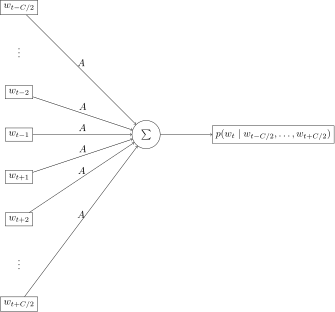

In [5]:
%%tikz

\begin{tikzpicture}[node distance=1.5cm, align=center]
    % Definición de nodos
    \node (w0) [rectangle, draw] {$w_{t - C/2}$};
    \node (dots1) [below of=w0] {$\vdots$};
    \node (w1) [rectangle, draw, below of=dots1] {$w_{t-2}$};
    \node (w2) [rectangle, draw, below of=w1] {$w_{t-1}$};
    \node (w3) [rectangle, draw, below of=w2] {$w_{t+1}$};
    \node (w4) [rectangle, draw, below of=w3] {$w_{t+2}$};
    \node (dots2) [below of=w4] {$\vdots$};
    \node (w5) [rectangle, draw, below of=dots2] {$w_{t+C/2}$};
    
    \node (cbow) [circle, draw, right of=w2, xshift=3cm, minimum size=1cm] {$\sum$};
    \node (wt) [rectangle, draw, right of=cbow, xshift=3cm] {$p(w_t\mid w_{t-C/2},\dots,w_{t+C/2})$};
 
    % Flechas
    \draw[->] (w0) -- (cbow) node[midway, above] {$A$};            
    \draw[->] (w1) -- (cbow) node[midway, above] {$A$};   
    \draw[->] (w2) -- (cbow) node[midway, above] {$A$};   
    \draw[->] (w3) -- (cbow) node[midway, above] {$A$};   
    \draw[->] (w4) -- (cbow) node[midway, above] {$A$};   
    \draw[->] (w5) -- (cbow) node[midway, above] {$A$};   
    \draw[->] (cbow) -- (wt);
\end{tikzpicture}



## Torch Dataset for CBOW training

##### Task: 

Create a torch dataset that, on iteration, returns pairs of samples ready to train the neural probabilistic language model CBOW. The structure of your torch dataset must be something like:

```python
class CBOWDataset(torch.utils.data.Dataset):
    def __init__(self, text, context_size, tokenizer):
        ...
        
    def _build_dataset(self, text):
        """Method for building training pairs from text"""
        ...

    def __len__(self):
        ...

    @property
    def vocab_size(self):
        return self.tokenizer.vocab_size
    
    def __getitem__(self, idx):
        ...
```


In [6]:
if assesment_draw_and_fill:
    code = """
```python
class CBOWDataset(torch.utils.data.Dataset):
    def __init__(self, text, context_size, tokenizer):

        self.tokenizer = tokenizer
        self.context_size = context_size

        self._build_dataset(text)
        
    def _build_dataset(self, text):

        print("Tokenizing input text. Please wait...")
        tokenized_text = ...

        print("Building pairs of training inputs and labels...")
        X = []
        T = []
        for i in range(self.context_size, len(tokenized_text) - self.context_size):
            context = (
                [tokenized_text[i - j - 1] for j in range(self.context_size)]
                + [tokenized_text[i + j + 1] for j in range(self.context_size)]
            )
            target = tokenized_text[i]
            
            X.append(context)
            T.append(target)

        self.X = torch.tensor(...)
        self.T = torch.tensor(...)

    def __len__(self):
        return ...

    @property
    def vocab_size(self):
        return self.tokenizer.vocab_size
    
    def __getitem__(self, idx):
        return ...
```
"""

    display(Markdown(code))


```python
class CBOWDataset(torch.utils.data.Dataset):
    def __init__(self, text, context_size, tokenizer):

        self.tokenizer = tokenizer
        self.context_size = context_size

        self._build_dataset(text)
        
    def _build_dataset(self, text):

        print("Tokenizing input text. Please wait...")
        tokenized_text = ...

        print("Building pairs of training inputs and labels...")
        X = []
        T = []
        for i in range(self.context_size, len(tokenized_text) - self.context_size):
            context = (
                [tokenized_text[i - j - 1] for j in range(self.context_size)]
                + [tokenized_text[i + j + 1] for j in range(self.context_size)]
            )
            target = tokenized_text[i]
            
            X.append(context)
            T.append(target)

        self.X = torch.tensor(...)
        self.T = torch.tensor(...)

    def __len__(self):
        return ...

    @property
    def vocab_size(self):
        return self.tokenizer.vocab_size
    
    def __getitem__(self, idx):
        return ...
```


In [7]:
class CBOWDataset(torch.utils.data.Dataset):
    def __init__(self, text, context_size, tokenizer):

        self.tokenizer = tokenizer
        self.context_size = context_size

        self._build_dataset(text)
        
    def _build_dataset(self, text):

        print("Tokenizing input text. Please wait...")
        tokenized_text = self.tokenizer.encode(text)

        print("Building pairs of training inputs and labels...")
        X = []
        T = []
        for i in range(self.context_size, len(tokenized_text) - self.context_size):
            context = (
                [tokenized_text[i - j - 1] for j in range(self.context_size)]
                + [tokenized_text[i + j + 1] for j in range(self.context_size)]
            )
            target = tokenized_text[i]
            
            X.append(context)
            T.append(target)

        self.X = torch.tensor(X)
        self.T = torch.tensor(T)

    def __len__(self):
        return len(self.T)

    @property
    def vocab_size(self):
        return self.tokenizer.vocab_size
    
    def __getitem__(self, idx):
        return self.X[idx], self.T[idx]

##### Task

Read data from source, create a tokenizer, train your tokenizer and create an instance of CBOWDataset. Finally, create a dataloader.


In [8]:
if assesment_draw_and_fill:
    code = """
```python
## read data from source to train language model on 
raw_data = ""

## reading dataset with PDF Plumber
...

## define context size
CONTEXT_SIZE = 2 # 2 words to the left, 2 to the right

## define tokenizer and train it
tokenizer = ...
...

## Create dataset instance
text_dataset = CBOWDataset(..., ..., ...)


## Create dataloader
cbow_loader = torch.utils.data.DataLoader(
                                                dataset = ...,
                                                batch_size = ..., 
                                                shuffle=True,
                                                num_workers=0,
                                            )
```
"""

    display(Markdown(code))


```python
## read data from source to train language model on 
raw_data = ""

## reading dataset with PDF Plumber
...

## define context size
CONTEXT_SIZE = 2 # 2 words to the left, 2 to the right

## define tokenizer and train it
tokenizer = ...
...

## Create dataset instance
text_dataset = CBOWDataset(..., ..., ...)


## Create dataloader
cbow_loader = torch.utils.data.DataLoader(
                                                dataset = ...,
                                                batch_size = ..., 
                                                shuffle=True,
                                                num_workers=0,
                                            )
```


In [9]:
## read data from source to train language model on 
raw_data = ""

## reading dataset with PDF Plumber
with pdfplumber.open('data/texto_pdf.pdf') as pdf:
    for page in pdf.pages:
        raw_data += page.extract_text()

## define context size
CONTEXT_SIZE = 2 # 2 words to the left, 2 to the right

## define tokenizer and train it
tokenizer = Tokenizer()
tokenizer.train_tokenizer(raw_data)

## create dataset instance
text_dataset = CBOWDataset(raw_data, CONTEXT_SIZE, tokenizer)

## create dataloader
cbow_loader = torch.utils.data.DataLoader(
                                                dataset = text_dataset,
                                                batch_size = 100, 
                                                shuffle=True,
                                                num_workers=0,
                                            )

Normalizing data...
Pre tokenizing data...
Building vocabulary...
Building ids to word mappings...
Tokenizing input text. Please wait...
Building pairs of training inputs and labels...


## Torch nn CBOW Model 

##### Task 

Implement a torch nn module that implements the CBOW probabilistic model. Use the following structure:

```python
class CBOW(nn.Module):

    def __init__(self, d_embedding, vocab_size):
        ...
        
    def forward(self, context_ids):
        ...
        
    def compute_loss(self,y,t):
        ...
```

Then create a model instance. Choose whatever embedding dimension you want. Example:

```python
## Create model
model = CBOW(d_embedding = 400, vocab_size = text_dataset.vocab_size)
```

In [10]:
if assesment_draw_and_fill:
    code = """
```python
class CBOW(nn.Module):
    def __init__(self, d_embedding, vocab_size):
        super().__init__()
        
        self.embedding_matrix = ...
        self.A = ... 
        self.loss = ...
        
    def forward(self, context_ids):
        ...
        return torch.matmul(..., ...)
        
    def compute_loss(self,y,t):
        return ...
```
"""

    display(Markdown(code))


```python
class CBOW(nn.Module):
    def __init__(self, d_embedding, vocab_size):
        super().__init__()
        
        self.embedding_matrix = ...
        self.A = ... 
        self.loss = ...
        
    def forward(self, context_ids):
        ...
        return torch.matmul(..., ...)
        
    def compute_loss(self,y,t):
        return ...
```


In [11]:
class CBOW(nn.Module):

    def __init__(self, d_embedding, vocab_size):
        super().__init__()
        
        self.embedding_matrix = nn.Parameter(torch.randn(vocab_size, d_embedding))
        self.A = nn.Parameter(torch.randn(d_embedding, vocab_size))
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, context_ids):
        e = self.embedding_matrix[context_ids,:]
        return torch.matmul(torch.sum(e,-2), self.A)
        
    def compute_loss(self,y,t):
        return self.loss(y,t)



In [12]:
## Create model instance
model = CBOW(d_embedding = 400, vocab_size = text_dataset.vocab_size)

## Learn Language Model

Note that embeddings are vector living in a high dimensional euclidean space. We could find similar vectors either by using the euclidean distance or by measuring how aligned the vectors are. For many reasons (see the theoretical description) we use alignment.

Two vectors are aligned when their angle is $0$. Thus, we can use the dot product to compute how aligned two vectors are since:

$$
a\cdot b = \mid a\mid\mid b\mid \cos \theta
$$

When $\cos \theta$ is $1$ the vectors are totally aligned. 

##### Task: Implement a function that receives a list of words, the embedding matrix, the tokenizer and a parameter K, and displays the K most similar words. The structure of function should be:

```python
def find_closest_words(words_to_inspect,embedding_matrix,tokenizer, K):
    ...
```

In [13]:
if assesment_draw_and_fill:
    code = """
```python
def find_closest_words(words_to_inspect, embedding_matrix, tokenizer, K):
    norm_embedding_matrix = (embedding_matrix**2).sum(1).sqrt()
    
    ## for each token find closest vectors using dot product (NOTE this could be easily done in a single matrix product, however did
    #  this way since it is more didactic.
    for word, token in zip(...,...):
        word_embedding = ...
    
        norm = (word_embedding**2).sum().sqrt()
    
        # distances via angle of vectors
        vectors_angle = torch.matmul(...,...) / (... * ...)
    
        # sort distances and get ids
        sorted_distances, sorted_ids = torch.sort(..., descending = True) 
    
        # to decode adequately 
        sorted_ids = [[s] for s in sorted_ids.squeeze().numpy().tolist()]
    
        # decode the list of sorted_ids into their corresponding words
        closest_word = ...
    
    
        print("=========================================")
        print(f"For word: {word} ")
        print(f"Closest words: {closest_word[0:K]}")
```
"""

    display(Markdown(code))    


```python
def find_closest_words(words_to_inspect, embedding_matrix, tokenizer, K):
    norm_embedding_matrix = (embedding_matrix**2).sum(1).sqrt()
    
    ## for each token find closest vectors using dot product (NOTE this could be easily done in a single matrix product, however did
    #  this way since it is more didactic.
    for word, token in zip(...,...):
        word_embedding = ...
    
        norm = (word_embedding**2).sum().sqrt()
    
        # distances via angle of vectors
        vectors_angle = torch.matmul(...,...) / (... * ...)
    
        # sort distances and get ids
        sorted_distances, sorted_ids = torch.sort(..., descending = True) 
    
        # to decode adequately 
        sorted_ids = [[s] for s in sorted_ids.squeeze().numpy().tolist()]
    
        # decode the list of sorted_ids into their corresponding words
        closest_word = ...
    
    
        print("=========================================")
        print(f"For word: {word} ")
        print(f"Closest words: {closest_word[0:K]}")
```


In [14]:
def find_closest_words(words_to_inspect, embedding_matrix, tokenizer, K):
    norm_embedding_matrix = (embedding_matrix**2).sum(1).sqrt()
    
    ## for each token find closest vectors using dot product (NOTE this could be easily done in a single matrix product, however did
    #  this way since it is more didactic.
    for word, token in zip(words_to_inspect,tokenizer.batch_encode(words_to_inspect)):
        word_embedding = embedding_matrix[token,:]
    
        norm = (word_embedding**2).sum().sqrt()
    
        # distances via angle of vectors
        vectors_angle = torch.matmul(word_embedding,embedding_matrix.t()) / (norm * norm_embedding_matrix)
    
        # sort distances and get ids
        sorted_distances, sorted_ids = torch.sort(vectors_angle, descending = True) 
    
        # to decode adequately 
        sorted_ids = [[s] for s in sorted_ids.squeeze().numpy().tolist()]
    
        # decode the list of sorted_ids into their corresponding words
        closest_word = tokenizer.batch_decode(sorted_ids)
    
    
        print("=========================================")
        print(f"For word: {word} ")
        print(f"Closest words: {closest_word[0:K]}")

    

#####  Task Inspect embeddings before training

Call the function and on a vector of words, for example:

```python
words_to_inspect = ['red', 'neuronal','datos', 'maquina', 'tesla', 'imagen', 'coches','foto', 'machine', 'learning','colores']
```

In [15]:
words_to_inspect = ['red', 'neuronal','datos', 'maquina', 'tesla', 'imagen', 'coches','foto', 'machine', 'learning','colores']
embedding_matrix = model.embedding_matrix

find_closest_words(words_to_inspect, embedding_matrix, tokenizer, K = 10)

For word: red 
Closest words: ['red', 'rompecabezas', 'usan', 'linea', 'procesar', 'adelante', 'vertical', 'respuesta', 'esos', 'final']
For word: neuronal 
Closest words: ['neuronal', 'podian', 'precisa', 'capas', 'ahorrar', 'automatico', 'correcta', 'detectan', 'habeis', 'numero']
For word: datos 
Closest words: ['datos', 'o', ':', 'estructura', 'hacer', 'finalmente', 'audio', 'estudiar', 'diferente', 'conducen']
For word: maquina 
Closest words: ['maquina', 'pueden', 'puntos', 'predecir', 'capaz', 'otras', 'practico', 'seguridad', 'identificar', 'rompecabezas']
For word: tesla 
Closest words: ['tesla', 'juntas', 'eso', 'reconocemos', 'esas', 'peatones', 'semaforos', 'cuantas', 'lo', 'del']
For word: imagen 
Closest words: ['imagen', 'encargarian', 'puntos', 'cruzada', 'con', '.', 'su', 'aplicaciones', 'todo', '"']
For word: coches 
Closest words: ['coches', 'dato', 'cosas', 'antes', 'procesamiento', 'tipico', 'principio', 'problemas', 'complejo', 'va']
For word: foto 
Closest words:

##### Task: Train Model

Train your model in an optimization loop. As learning algorithm you can choose SGD with momentum or Adam. You are also free of experimenting with learning rate and so on so that your loss minimize adequately.

In [16]:
if assesment_draw_and_fill:
    code = """
```python
## Optimizer
optimizer = ...
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.1)

epochs = ...
for e in range(epochs):
    loss_acc = 0.0
    for batch_idx, ... in enumerate(...):
        
        ## forward
        y = ...
        L = ...
        
        ## backward
        L...
        loss_acc += L.item()
        
        ## update
        ...
        
        ## zero grad
        ...

        print(f"Running batch_idx {batch_idx}/{len(cbow_loader)}", end = "\r")

    ## update scheduler
    scheduler.step()
 
    print(f"Loss epoch {e} got {loss_acc}")   
```
"""

    display(Markdown(code))    


```python
## Optimizer
optimizer = ...
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.1)

epochs = ...
for e in range(epochs):
    loss_acc = 0.0
    for batch_idx, ... in enumerate(...):
        
        ## forward
        y = ...
        L = ...
        
        ## backward
        L...
        loss_acc += L.item()
        
        ## update
        ...
        
        ## zero grad
        ...

        print(f"Running batch_idx {batch_idx}/{len(cbow_loader)}", end = "")

    ## update scheduler
    scheduler.step()
 
    print(f"Loss epoch {e} got {loss_acc}")   
```


In [17]:
## Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

epochs = 300
for e in range(epochs):
    loss_acc = 0.0
    for batch_idx, (x,t) in enumerate(cbow_loader):
        
        ## forward
        y = model(x)
        L = model.compute_loss(y,t)
        
        ## backward
        L.backward()
        loss_acc += L.item()
        
        ## update
        optimizer.step()
        
        ## zero grad
        optimizer.zero_grad()

        print(f"Running batch_idx {batch_idx}/{len(cbow_loader)}", end = "\r")

    ## update scheduler
    scheduler.step()
 
    print(f"Loss epoch {e} got {loss_acc}")   

Loss epoch 0 got 1286.0601959228516
Loss epoch 1 got 1194.0753707885742
Loss epoch 2 got 1092.0502624511719
Loss epoch 3 got 997.8328399658203
Loss epoch 4 got 904.7905502319336
Loss epoch 5 got 820.1842727661133
Loss epoch 6 got 748.4465370178223
Loss epoch 7 got 693.8679733276367
Loss epoch 8 got 643.9393653869629
Loss epoch 9 got 583.1517333984375
Loss epoch 10 got 546.1926612854004
Loss epoch 11 got 505.1980667114258
Loss epoch 12 got 466.46518325805664
Loss epoch 13 got 428.6425018310547
Loss epoch 14 got 390.2106113433838
Loss epoch 15 got 363.07573318481445
Loss epoch 16 got 331.552490234375
Loss epoch 17 got 305.2742214202881
Loss epoch 18 got 279.4083023071289
Loss epoch 19 got 260.23000717163086
Loss epoch 20 got 244.67745399475098
Loss epoch 21 got 216.20709037780762
Loss epoch 22 got 197.71891975402832
Loss epoch 23 got 183.1949348449707
Loss epoch 24 got 165.3056697845459
Loss epoch 25 got 151.38202095031738
Loss epoch 26 got 137.43899059295654
Loss epoch 27 got 120.453368

##### Task: Inspect learned embeddings

Call again the function on the same list as before and inspect which are now the closest embeddings
Let's see what the model has learned.

In [18]:
words_to_inspect = ['red', 'neuronal','datos', 'maquina', 'tesla', 'imagen', 'coches','foto', 'machine', 'learning','colores']
embedding_matrix = model.embedding_matrix

find_closest_words(words_to_inspect, embedding_matrix, tokenizer, K = 10)

For word: red 
Closest words: ['red', 'rompecabezas', 'linea', 'vertical', 'respuesta', 'redes', 'usan', 'simples', 'adelante', 'utiles']
For word: neuronal 
Closest words: ['neuronal', 'precisa', 'podian', 'o', 'capas', 'ahorrar', 'detectan', 'habeis', 'automatico', 'numero']
For word: datos 
Closest words: ['datos', 'estructura', 'hacer', 'o', 'conducen', 'audio', ':', 'finalmente', 'estudiar', 'diferente']
For word: maquina 
Closest words: ['maquina', 'pueden', 'puntos', 'predecir', 'seguridad', 'practico', 'otras', 'learning', 'rompecabezas', 'capaz']
For word: tesla 
Closest words: ['tesla', 'juntas', 'eso', 'reconocemos', 'es', 'alrededor', 'peatones', 'del', 'esas', 'semaforos']
For word: imagen 
Closest words: ['imagen', 'puntos', 'encargarian', 'cruzada', 'aplicaciones', 'con', '.', 'todo', 'parecido', 'su']
For word: coches 
Closest words: ['coches', 'dato', 'antes', 'cosas', 'y', 'procesamiento', 'tipico', 'principio', 'con', 'complejo']
For word: foto 
Closest words: ['foto

# Optional: implement the skip gram neural probabilistic language model